# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# Import the needed functions from common_utils
from common_utils import Custom_MLP, EarlyStopper, split_dataset, preprocess_dataset, intialise_loaders, loss_fn

2. Install and import shap

In [3]:
# Import shap
import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [4]:
# Define the dataset variables
df = 0
size_row = 0
size_column = 0

# Load the csv data preprocessed from 'record.wav'
df = pd.read_csv("new_record.csv")  # read the csv data preprocessed from 'record.wav'
df = df.drop(['filename'], axis=1)  # remove the 'filename'
size_row, size_column = df.shape  # Get the dimensions of the dataframe

# Display the csv data preprocessing from 'record.wav'
df

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,112.347147,51,25.5,0.478502,0.111069,0.579547,0.091646,0.268037,0.01149,0.021869,...,-4.068467,46.23243,-4.134901,53.040028,-0.942353,35.105537,-3.529712,54.78144,-3.722851,53.242012


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [5]:

def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    scaler = preprocessing.StandardScaler()  # Define the scaler
    scaler.fit(X_train)  # Fit the scaler to the training data
    X_test_scaled_eg = scaler.transform(df)  # Transform the test data
    
    return X_test_scaled_eg

df_train = pd.read_csv("simplified.csv")  # Read the csv data preprocessed from 'record.wav'
df_train['label'] = df_train['filename'].str.split('_').str[-2]  # Extract the label from the filename
X_train, y_train, X_test, y_test = split_dataset(df_train, ['filename', 'label'], 0.3, 0)  # Split the dataset into training and testing

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)  # Preprocess the dataset
X_test_scaled_eg = preprocess(X_train, df)  # Preprocess the test dataset

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [6]:
# Define the optimal batch size and the optimal network architecture
batch_size = 128
net_architecture = [256, 256, 256]

# Define the number of features
no_features = X_train_scaled.shape[1]

# Define the model
model = Custom_MLP(no_features, net_architecture, 1)  # Define the model

# Define the specified parameters
patience = 3  # Define the patience for early stopping
no_epochs = 100  # Define the number of epochs for training

# Define the variables to store the training and test accuracies
train_accuracies = []
train_after_accuracies = []
test_accuracies = []

# Define the variables to store the training and test losses
train_losses = []
train_after_losses = []
test_losses = []

# Define the loss function and the optimizer
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size)

# Define the early stopping function
early_stopper = EarlyStopper(patience=patience) 

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer

# Train the model for the specified number of epochs
for epoch in range(1, no_epochs + 1):
    # Set the model to training mode
    model.train()
    
    # Perform mini-batch gradient descent for the training dataset and compute the training accuracy and loss during the training process
    train_loss, train_accuracy = 0, 0  # Define the variables to store the training loss and accuracy
    train_no_batches = len(train_dataloader)  # Define the number of mini-batches in the training dataset
    train_size = len(train_dataloader.dataset) # Define the size of the dataset# Define the size of the dataset
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients
        y_pred = model(X_batch)  # Perform a forward pass of the model
        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters
        
        # Compute the training accuracy and loss for the current batch
        train_loss += loss.item()  # Add the loss value to the running total
        train_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
    
    # Compute the average training accuracy and loss values
    train_accuracy /= train_size  # Compute the average training accuracy
    train_loss /= train_no_batches  # Compute the average training loss
    train_accuracies.append(train_accuracy)  # Append the training accuracy to the list
    train_losses.append(train_loss)  # Append the training loss to the list
    
    # Set the model to evaluation mode
    model.eval()
    # Disable gradient computation using the no_grad context, reducing memory consumption
    with torch.no_grad():
        test_loss, test_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the test dataset
        test_no_batches = len(test_dataloader)  # Define the number of mini-batches in the test dataset
        test_size = len(test_dataloader.dataset) # Define the size of the dataset
        
        # Compute the test accuracy and loss
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)  # Perform a forward pass of the model
            loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
            
            # Compute the test accuracy and loss for the current batch
            test_loss += loss.item()  # Add the loss value to the running total
            test_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
        
        # Compute the average test and test accuracy and loss values
        test_accuracy /= test_size  # Compute the average test accuracy
        test_loss /= test_no_batches  # Compute the average test loss
        test_accuracies.append(test_accuracy)  # Append the test accuracy to the list
        test_losses.append(test_loss)  # Append the test loss to the list
        
        # Compute the training accuracy and loss for the current epoch after training for the epoch has finished
        train_after_loss, train_after_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the training dataset
        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch)  # Perform a forward pass of the model
            loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
            
            # Compute the training accuracy and loss
            train_after_loss += loss.item()  # Add the loss value to the running total
            train_after_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
        
        # Compute the average training accuracy and loss values
        train_after_accuracy /= train_size  # Compute the average training accuracy
        train_after_loss /= train_no_batches  # Compute the average training loss
        train_after_accuracies.append(train_after_accuracy)  # Append the training accuracy to the list
        train_after_losses.append(train_after_loss)  # Append the training loss to the list
        
    # Print the training and test accuracies and losses for the current epoch
    print(f"Epoch {epoch}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}, Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    # Check for early stopping
    if early_stopper.early_stop(test_loss):
        print(f"Validation loss has not decreased for the last {patience} epochs. Early stopping...")
        break

Epoch 1: Train Accuracy = 0.5624, Test Accuracy = 0.5826, Train Loss = 0.6823, Test Loss = 0.6760
Epoch 2: Train Accuracy = 0.6029, Test Accuracy = 0.6111, Train Loss = 0.6611, Test Loss = 0.6529
Epoch 3: Train Accuracy = 0.6327, Test Accuracy = 0.6329, Train Loss = 0.6379, Test Loss = 0.6415
Epoch 4: Train Accuracy = 0.6571, Test Accuracy = 0.6407, Train Loss = 0.6145, Test Loss = 0.6256
Epoch 5: Train Accuracy = 0.6834, Test Accuracy = 0.6708, Train Loss = 0.5907, Test Loss = 0.6050
Epoch 6: Train Accuracy = 0.7065, Test Accuracy = 0.6708, Train Loss = 0.5626, Test Loss = 0.5977
Epoch 7: Train Accuracy = 0.7302, Test Accuracy = 0.6926, Train Loss = 0.5322, Test Loss = 0.5891
Epoch 8: Train Accuracy = 0.7532, Test Accuracy = 0.6976, Train Loss = 0.5015, Test Loss = 0.5782
Epoch 9: Train Accuracy = 0.7643, Test Accuracy = 0.7164, Train Loss = 0.4789, Test Loss = 0.5611
Epoch 10: Train Accuracy = 0.7846, Test Accuracy = 0.7123, Train Loss = 0.4569, Test Loss = 0.5480
Epoch 11: Train Acc

6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


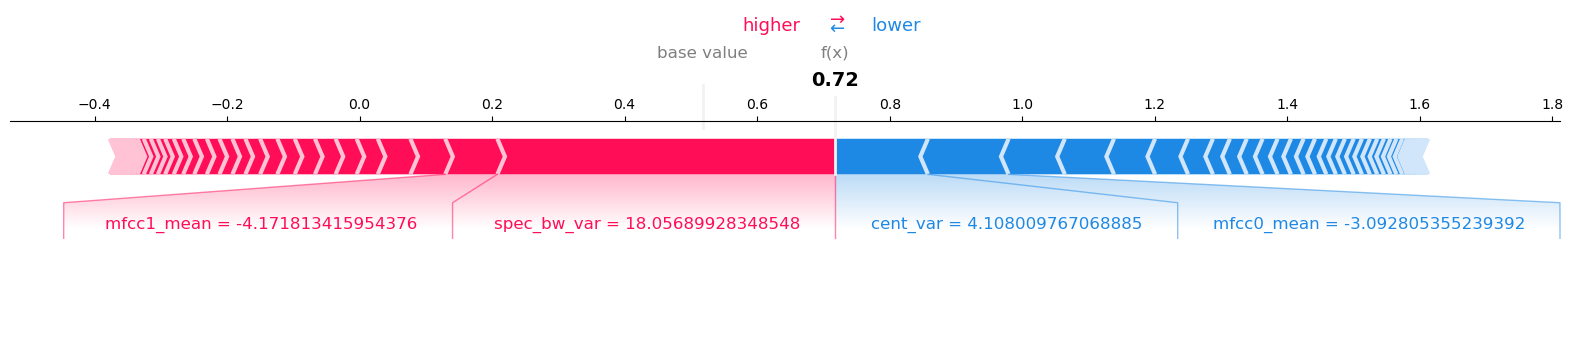

In [7]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
shap.initjs()
explainer = shap.DeepExplainer(model, torch.tensor(X_train_scaled, dtype=torch.float))
explainer_values = explainer.shap_values(torch.tensor(X_test_scaled_eg, dtype=torch.float))
shap.force_plot(explainer.expected_value, shap_values=explainer_values, features=X_test_scaled_eg, feature_names=X_train.columns, matplotlib=True)


In [8]:
observation = """
Based on the sharp plot above, spec_bw_var is the variable that has the highest positive influence in the prediction model, followed by mfcc1_mean, while cent_var has the highest negative influence, followed by mfcc0_mean. The sharp plot shows the impact of each feature on the model's output for the prediction. The sharp plot is useful for understanding the model's prediction and the impact of each feature on the model's output.
"""
print(observation)


Based on the sharp plot above, spec_bw_var is the variable that has the highest positive influence in the prediction model, followed by mfcc1_mean, while cent_var has the highest negative influence, followed by mfcc0_mean. The sharp plot shows the impact of each feature on the model's output for the prediction. The sharp plot is useful for understanding the model's prediction and the impact of each feature on the model's output.
